# Molecular VAE

In [1]:
# imports
import pandas as pd
import numpy as np
import re
import torch
import torch.utils.data as tud
from torch import nn
from torch.nn import functional as F

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# chemistry
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True  #set this to False if you want PNGs instead of SVGs

RDKit WARNING: [17:09:43] Enabling RDKit 2019.09.1 jupyter extensions


## Load data

In [2]:
chembl = pd.read_csv("data/cleaned_dataset.csv")
chembl.head()

,ChEMBL ID,Smiles,AlogP,QED Weighted
0,CHEMBL2333117,CC(C)Nc1c(C(N)=O)nnc2ccc(-c3cnn(C)c3)cc12,1.95,0.77
1,CHEMBL1189585,CC1C(=O)NC2=Nc3sc4c(c3CN21)CCCC4,1.95,0.78
2,CHEMBL4089494,CNC(=O)c1ccc(NC(=O)Nc2ccc(-c3nc(N4CCOCC4)c4ncc...,3.53,0.40
3,CHEMBL1189590,CN(C)c1nccc2c1nnn2Cc1ccccc1F,2.08,0.73
4,CHEMBL3927722,Cc1noc(C)c1Cn1cc(NC(=O)Cc2ccco2)cn1,2.31,0.78


## Data preparation & encoding

Steps to prepare VAE input data:
1. SMILES tokenization (add start/end tokens)
2. SMILES token encoding (convert to integer indecies) -> build a vocabulary
3. Set up a SMILES dataset class (for feeding batches of data to the VAE)

### Utility classes/functions

In [3]:
class SMILESTokenizer(object):
    
    def __init__(self, pattern="(Br|Cl)", start="<sos>", end="<eos>"):
        self.pattern = re.compile(pattern)
        self.start = start
        self.end = end
        
    def getStart(self):
        return self.start
    
    def getEnd(self):
        return self.end
    
    def getPattern(self):
        """Returns compiled regex pattern for multi-character tokens"""
        return self.pattern

    def tokenize(self, smi:str, use_start_end:bool=True) -> list:
        """Tokenizes an input SMILES string"""
        start = [self.start] if self.start else []
        end = [self.end] if self.end else []
        if not self.pattern:
            if use_start_end:
                return start + list(smi) + end
            else:
                return list(smi)
        # split input SMILES string using the supplied regex pattern    
        splitted = self.pattern.split(smi)
        tokens = []
        for i, s in enumerate(splitted):
            # make sure Br and Cl are treated as a single token
            if i % 2 == 0:
                tokens.extend(list(s))
            else:
                tokens.append(s)
        if use_start_end:
            return start + tokens + end
        else:
            return tokens

    def untokenize(self, tokens:list) -> str:
        """Concatenates a list of tokens into a SMILES string"""
        smiles = ""
        for t in tokens:
            if self.start and t == self.start:
                continue
            if self.end and t == self.end:
                continue
            else:
                smiles += t
        return smiles
    

class SMILESVocabulary(object):
    """Keeps track of string tokens and their associated integer indecies"""
    
    def __init__(self):
        self._tokens_idxs = {} # vocabulary
        self._current_idx = 0 # currently available index

    def __getitem__(self, token_or_idx):
        return self._tokens_idxs[token_or_idx]
    
    def __len__(self):
        return len(self._tokens_idxs) // 2
    
    def add(self, token:str):
        assert type(token) == str, "Token must be of type string."
        if token not in self._tokens_idxs:
            self._tokens_idxs[token] = self._current_idx
            self._tokens_idxs[self._current_idx] = token
            # update first available index
            self._current_idx += 1
            
    def tokens(self):
        """Returns a list of all tokens in the vocabulary"""
        return [t for t in self._tokens_idxs if type(t) == str]

    def update(self, tokens:list):
        """Updates the vocabulary with an iterable of tokens"""
        for t in tokens:
            self.add(t)
        
    def encode(self, tokens:list) -> list:
        """Encodes a list of tokens as a list of integer indecies"""
        return [self._tokens_idxs[t] for t in tokens]
    
    def decode(self, indecies:list) -> list:
        """Decodes a list of interger indecies as a list of tokens"""
        return [self._tokens_idxs[t] for t in indecies]

    def build(self, smiles:list, tokenizer:SMILESTokenizer) -> None:
        """
        Builds a vocabulary using a list of SMILES and
        an instance of a Tokenizer object. Any existing
        vocabulary is reset.
        -------------------------------
        smiles - iterable of SMILES strings
        tokenizer - instantiated SMILESTokenizer object
        
        returns None
        """
        # reset current vocabulary
        self.__init__()
        # build new vocabulary
        tokens = set()
        for smi in smiles:
            tokens.update(tokenizer.tokenize(smi, use_start_end=False))
        # end-of-seq token gets idx 0 and start-of-seq token gets idx 1
        self.update([tokenizer.getEnd(), tokenizer.getStart()] + sorted(tokens))
        
    def save(self, path):
        """Saves the vocabulary to disk"""
        voc = [[k, v] for k, v in self._tokens_idxs.items() if isinstance(k, str)]
        voc_df = pd.DataFrame(voc, columns=["token", "index"])
        voc_df.to_csv(path, index=False)
    
    def load(self, path):
        """Loads a stored vocabulary from disk"""
        # reset current vocabulary
        self.__init__()
        # build vocabulary from csv file
        voc_df = pd.read_csv(path)
        for _, row in voc_df.iterrows():
            token = row["token"]
            idx = row["index"]
            self._tokens_idxs[token] = idx
            self._tokens_idxs[idx] = token
            self._current_idx = max(self._current_idx, idx)
        # update the currently available index
        self._current_idx += 1


class SMILESDataset(tud.Dataset):
    """Custom dataset class for producing batches of SMILES"""
    
    def __init__(self, smiles, vocabulary:SMILESVocabulary, tokenizer:SMILESTokenizer):
        """
        Creates a dataset from an iterable of SMILES, a built vocabulary of tokens
        and a SMILES tokenizer.
        """
        super().__init__()
        self._smiles = list(smiles)
        self._vocabulary = vocabulary
        self._tokenizer = tokenizer
        
    def __getitem__(self, idx):
        """Returns a molecule at index idx as an encoded SMILES tensor"""
        smi = self._smiles[idx]
        smi_enc = vocabulary.encode(tokenizer.tokenize(smi))
        return torch.LongTensor(smi_enc)
    
    def __len__(self):
        return len(self._smiles)
    
    @staticmethod
    def collate_fn(enc_tensors):
        """
        Pads encoded SMILES tensors to the same max. length using 0:s
        The output tensor has shape: (batch_sz, max. length)
        """
        batch_sz = len(enc_tensors)
        max_len = max([t.size(0) for t in enc_tensors])
        padded = torch.zeros((batch_sz, max_len), dtype=torch.long)
        # pad encoded batch of SMILES
        for i, t in enumerate(enc_tensors):
            padded[i, :t.size(0)] = t
        return padded


def countTokens(smiles:list, tokenizer:SMILESTokenizer, tokenCol:str="token", cntCol:str="cnt") -> pd.DataFrame:
    """Computes the token frequency in the smiles iterable"""
    token_cnts = {}
    for smi in smiles:
        # tokenize SMILES string
        tokenized = tokenizer.tokenize(smi, use_start_end=False)
        # count tokens
        for t in tokenized:
            try:
                token_cnts[t] += 1
            except KeyError:
                token_cnts[t] = 1
    return pd.DataFrame([[t, c] for t, c in token_cnts.items()], columns=[tokenCol, cntCol])


### Analyze token frequencies

In [92]:
token_cnts = countTokens(chembl["Smiles"], tokenizer)
token_cnts

,token,cnt
0,C,12896279
1,(,7025189
2,),7025189
3,N,2682981
4,c,18431345
5,1,4604265
6,=,2904352
7,O,4388805
8,n,2124346
9,2,3590237


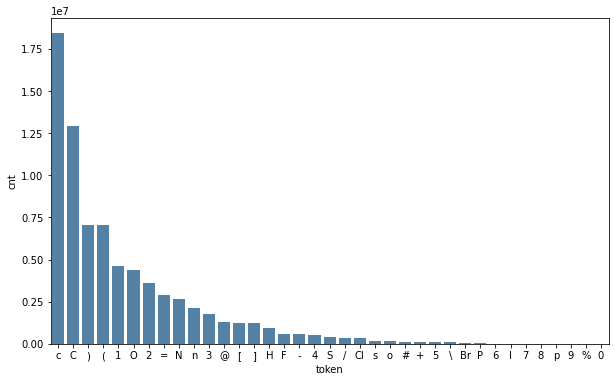

In [94]:
# plot token distribution
fig, ax = plt.subplots(figsize=(10, 6))
_ = sns.barplot(data=token_cnts.sort_values("cnt", ascending=False), x="token", y="cnt", color="steelblue", ax=ax)

### Build a vocabulary

In [4]:
tokenizer = SMILESTokenizer()
vocabulary = SMILESVocabulary()

In [96]:
# vocabulary.build(chembl["Smiles"], tokenizer)

In [99]:
# # save vocabulary
# vocabulary.save("data/vocabulary.csv")

In [5]:
# load vocabulary
vocabulary.load("data/vocabulary.csv")

### Build a dataset

In [6]:
dataset = SMILESDataset(chembl["Smiles"], vocabulary, tokenizer)

In [7]:
# test producing batches with dataloader
dataloader = tud.DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=SMILESDataset.collate_fn)

In [8]:
dloader_iter = iter(dataloader)

In [9]:
batch = next(dloader_iter)
batch

tensor([[ 1, 27, 31,  ...,  0,  0,  0],
        [ 1, 22, 28,  ...,  0,  0,  0],
        [ 1, 22, 28,  ...,  0,  0,  0],
        ...,
        [ 1, 22,  2,  ...,  0,  0,  0],
        [ 1, 28, 19,  ...,  0,  0,  0],
        [ 1, 22, 34,  ...,  0,  0,  0]])

In [21]:
batch.size()

torch.Size([16, 98])

## NN modules

The variational autoencoder consists of the following components:
1. SMILES encoder: maps input sequences to a latent vector z
2. Decoder: decodes a latent vector z into a sequence

In [28]:
class MolecularVAE(nn.Module):
    """
    Encodes a sequence as a probability distribution over a latent space - z
    and samples from this probability distribution.
    """
    
    def __init__(self, vocab_sz:int, embedding_dim:int, hidden_dim:int, latent_dim:int, sos_idx:int, eos_idx:int, 
                 rnn_layers:int=1, bidirectional:bool=True, pad_idx:int=0, dropout:float=0.0):
        """Parameter initialization"""
        super().__init__()
        # module params
        self.vocab_sz = vocab_sz
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.pad_idx = pad_idx
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.bidirectional = bidirectional
        self.rnn_layers = rnn_layers
        self.hidden_factor = (2 if self.bidirectional else 1) * self.rnn_layers
        
        # embedding layer (used by both encoder and decoder)
        self.embedding = nn.Embedding(self.vocab_sz, self.embedding_dim, padding_idx=self.pad_idx)
        
        # encoder RNN
        self.encoder_rnn = nn.GRU(self.embedding_dim, self.hidden_dim, num_layers=self.rnn_layers, 
                          batch_first=True, dropout=dropout, bidirectional=self.bidirectional)
        
        # linear layers for computing the params of the latent vector z distribution
        # (diagonal multivariate gaussian) from the hidden state vector of the RNN
        self.hidden2mean = nn.Linear(self.hidden_dim * self.hidden_factor, self.latent_dim)
        self.hidden2logv = nn.Linear(self.hidden_dim * self.hidden_factor, self.latent_dim)
        
        # linear layers for computing the decoder hidden vector from the latent vector
        self.latent2hidden = nn.Linear(self.latent_dim, self.hidden_dim * self.hidden_factor)
        
        # decoder layers
        self.decoder_rnn = nn.GRU(self.embedding_dim, self.hidden_dim, num_layers=self.rnn_layers, 
                  batch_first=True, dropout=dropout, bidirectional=self.bidirectional)
        self.outputs2vocab = nn.Linear(self.hidden_dim * (2 if self.bidirectional else 1), self.vocab_sz)
        
    def forward(self, input_seqs:torch.Tensor) -> (torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor):
        """
        Performs the encoding and reparametrization step.
        ------------------------
        input_seqs: input batch of sequences (batch size, seq. length)
        
        returns (z, mean, logv)
        """
        input_embeddings = self.embedding(input_seqs)
        # run sequence through the encoder
        mean, logv, stdev = self.encode(input_embeddings)
        # sample z from the posterior distribution
        z = self.samplePosterior(mean, stdev)
        # run through the decoder
        logits = self.decode(z, input_embeddings)
        return logits, z, mean, logv
    
    def encode(self, input_embeddings:torch.Tensor) -> (torch.Tensor, torch.Tensor, torch.Tensor):
        """Encodes a sequence as parametrized posterior distribution over the latent space - z"""
        _, hidden = self.encoder_rnn(input_embeddings)
        # flatten RNN output
        hidden = hidden.view(-1, self.hidden_factor * self.hidden_dim)
        # reparametrize (compute posterior distribution params)
        mean = self.hidden2mean(hidden)
        logv = self.hidden2logv(hidden)
        stdev = torch.exp(logv / 2)
        return mean, logv, stdev
        
    def decode(self, z:torch.Tensor, input_embeddings:torch.Tensor) -> torch.Tensor:
        """Decodes z as a distribution over the vocabulary for each position in the sequence"""
        batch_sz = z.size(0)
        hidden = self.latent2hidden(z)
        hidden = hidden.view(self.hidden_factor, batch_sz, self.hidden_dim)
        output, _ = self.decoder_rnn(input_embeddings, hidden)
        return F.softmax(self.outputs2vocab(output), dim=-1)
        
    def samplePrior(self, batch_sz:int) -> torch.Tensor:
        """Samples z from a unit multivariate Gaussian"""
        return torch.randn(batch_sz, self.latent_dim)

    def samplePosterior(self, mean:torch.Tensor, stdev:torch.Tensor) -> torch.Tensor:
        """
        Samples from the approximate multivariate Gaussian posterior parameterized by
        mean vector and diagonal covariance matrix.
        """
        batch_sz = mean.size(0)
        epsilon = self.samplePrior(batch_sz)
        return mean + stdev * epsilon
    
    def generateSequences(self, z:torch.Tensor, max_len:int=150, greedy:bool=False) -> torch.Tensor:
        """Generates a batch of sequences from latent space encodings."""
        batch_sz = z.size(0)
        sequences = torch.full([batch_sz, max_len], self.pad_idx, dtype=torch.long)
        sequences[:, 0] = self.sos_idx
        # define mask
        
        running_seqs = sequences.clone()
        for s in range(max_len):
            input_embeddings = self.embedding(sequences[:, :s+1])
            logits = decode(z, input_embeddings)
            # sample from softmax at sequence position - s
            next_idxs = self._sample(logits[:,-1,:])
            
    def _sample(self, logits:torch.Tensor, greedy:bool=False) -> torch.Tensor:
        """Samples idxs from a softmax distribution"""
        batch_sz = logits.size(0)
        rand = torch.rand(batch_sz).repeat(self.vocab_sz, 1).T
        cdf = logits.cumsum(-1)
        sample = (rand > cdf).long().sum(-1)
        return sample


In [29]:
vae = MolecularVAE(len(vocabulary), 8, 64, 128, rnn_layers=2, bidirectional=True, dropout=0.1)

In [30]:
logits, z, mean, logv = vae(batch)

torch.Size([4, 16, 64])
torch.Size([16, 98, 128])


In [27]:
logits.size()

torch.Size([16, 98, 39])

In [35]:
x = torch.zeros(3, 4, dtype=torch.long)

In [39]:
x[:, 0] = 1

In [46]:
torch.full([3, 4], 2, dtype=torch.long)

tensor([[2, 2, 2, 2],
        [2, 2, 2, 2],
        [2, 2, 2, 2]])

In [53]:
x[:,:6]

tensor([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]])

In [60]:
cumsum = logits[:,-1,:].cumsum(-1)
cumsum

tensor([[0.0299, 0.0480, 0.0705, 0.1018, 0.1289, 0.1576, 0.1916, 0.2205, 0.2444,
         0.2706, 0.2926, 0.3168, 0.3418, 0.3664, 0.3845, 0.4184, 0.4481, 0.4718,
         0.4932, 0.5217, 0.5399, 0.5661, 0.5902, 0.6220, 0.6424, 0.6630, 0.6873,
         0.7144, 0.7391, 0.7710, 0.7952, 0.8169, 0.8447, 0.8745, 0.9010, 0.9232,
         0.9476, 0.9751, 1.0000],
        [0.0261, 0.0569, 0.0866, 0.1138, 0.1423, 0.1651, 0.1965, 0.2209, 0.2497,
         0.2720, 0.2973, 0.3233, 0.3495, 0.3687, 0.3982, 0.4154, 0.4415, 0.4682,
         0.4888, 0.5126, 0.5340, 0.5593, 0.5778, 0.6063, 0.6290, 0.6498, 0.6809,
         0.7063, 0.7305, 0.7610, 0.7875, 0.8109, 0.8339, 0.8670, 0.8891, 0.9333,
         0.9529, 0.9747, 1.0000],
        [0.0264, 0.0505, 0.0754, 0.0974, 0.1267, 0.1502, 0.1774, 0.1962, 0.2227,
         0.2527, 0.2804, 0.3081, 0.3306, 0.3629, 0.3821, 0.4015, 0.4295, 0.4585,
         0.4874, 0.5154, 0.5369, 0.5612, 0.5823, 0.6145, 0.6411, 0.6654, 0.6878,
         0.7111, 0.7306, 0.7592, 0.7816, 

In [61]:
cumsum.size()

torch.Size([16, 39])

In [62]:
sample = torch.rand(16)
sample

tensor([0.3322, 0.9561, 0.7550, 0.2446, 0.5193, 0.7769, 0.0704, 0.3630, 0.4226,
        0.7019, 0.5724, 0.7982, 0.3781, 0.4372, 0.2969, 0.6745])

In [70]:
rsample = sample.repeat(39, 1).T
rsample

tensor([[0.3322, 0.3322, 0.3322, 0.3322, 0.3322, 0.3322, 0.3322, 0.3322, 0.3322,
         0.3322, 0.3322, 0.3322, 0.3322, 0.3322, 0.3322, 0.3322, 0.3322, 0.3322,
         0.3322, 0.3322, 0.3322, 0.3322, 0.3322, 0.3322, 0.3322, 0.3322, 0.3322,
         0.3322, 0.3322, 0.3322, 0.3322, 0.3322, 0.3322, 0.3322, 0.3322, 0.3322,
         0.3322, 0.3322, 0.3322],
        [0.9561, 0.9561, 0.9561, 0.9561, 0.9561, 0.9561, 0.9561, 0.9561, 0.9561,
         0.9561, 0.9561, 0.9561, 0.9561, 0.9561, 0.9561, 0.9561, 0.9561, 0.9561,
         0.9561, 0.9561, 0.9561, 0.9561, 0.9561, 0.9561, 0.9561, 0.9561, 0.9561,
         0.9561, 0.9561, 0.9561, 0.9561, 0.9561, 0.9561, 0.9561, 0.9561, 0.9561,
         0.9561, 0.9561, 0.9561],
        [0.7550, 0.7550, 0.7550, 0.7550, 0.7550, 0.7550, 0.7550, 0.7550, 0.7550,
         0.7550, 0.7550, 0.7550, 0.7550, 0.7550, 0.7550, 0.7550, 0.7550, 0.7550,
         0.7550, 0.7550, 0.7550, 0.7550, 0.7550, 0.7550, 0.7550, 0.7550, 0.7550,
         0.7550, 0.7550, 0.7550, 0.7550, 

In [78]:
(rsample > cumsum).long().sum(-1)

tensor([12, 37, 29,  9, 20, 30,  2, 13, 16, 27, 21, 30, 14, 17, 10, 26])